In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_gait_cycle(df, df_movement, movement):
    # Set the font to Arial
    plt.rcParams['font.family'] = 'Arial'

    # Set the size of the plot
    plt.figure(figsize=(10, 6), dpi=300)

    # Plot the data
    plt.plot(df['Time_Percentage'], df['Angle'], label='Prosthesis')
    plt.plot(df_movement['Time'], df_movement[movement], label='Reference', linestyle='--')

    # Add labels and title
    plt.xlabel('Gait Cycle (%)')
    plt.ylabel('Angle (°)')
    #plt.title('Dorsiflexion & Plantar Flexion')

    # Set X-axis ticks with a step of 10
    plt.xticks(range(0, 101, 10))

    # Set X-axis limits to 0 to 100
    plt.xlim(0, 100)

    # Add dashed vertical lines at specified percentages
    vertical_lines = [10, 30, 55, 65, 75, 85]
    for x in vertical_lines:
        plt.axvline(x=x, color='green', linestyle='--', alpha=0.35)

    # Add labels at the top of the chart between each vertical line
    labels = ['(MSt)', '(TSt)', '(PSw)', '(ISw)', '(MSw)']

    plt.text(0, df['Angle'].max() + 2.5, '(IC)', ha='center', va='bottom', fontsize=10, color='black')
    plt.text(vertical_lines[0] / 2, df['Angle'].max() + 2, '(LR)', ha='center', va='bottom', fontsize=10, color='black')
    plt.text(92.5, df['Angle'].max() + 2, '(TSw)', ha='center', va='bottom', fontsize=10, color='black')

    for i, x in enumerate(vertical_lines):
        if i < len(vertical_lines) - 1:
            mid_point = (vertical_lines[i] + vertical_lines[i + 1]) / 2
            plt.text(mid_point, df['Angle'].max() + 2, labels[i], ha='center', va='bottom', fontsize=10, color='black')

    # Add grid
    plt.grid(True)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

## Dataframe of Vicky 3km

In [3]:
df_vicky = pd.read_excel('tobillovicky3km.xlsx')
# Keep the rows between the value 50,30 and 51,51 in Time column
df_vicky = df_vicky[(df_vicky['Time'] >= 50.3) & (df_vicky['Time'] < 51.51)]

df_vicky['Time'] = df_vicky['Time'] - 50.3

# Calculate the total time
total_time = df_vicky['Time'].max()

# Create a new column for time percentage
df_vicky['Time_Percentage'] = (df_vicky['Time']/ total_time) * 100

# Make 3 datasets: ["Time", "last colum"], ["Time", "last colum"], ["Time", "last colum"]
df_rotacion = df_vicky.iloc[:, [-1, -2]]
df_rotacion.columns = ["Time", "Rotación"]

df_eversion = df_vicky.iloc[:, [-1, -3]]
df_eversion.columns = ["Time", "Eversión"]

df_dorsiflexion = df_vicky.iloc[:, [-1, -4]]
df_dorsiflexion.columns = ["Time", "Dorsiflexión"]

df_vicky.shape

(121, 11)

## Dorsiflexion

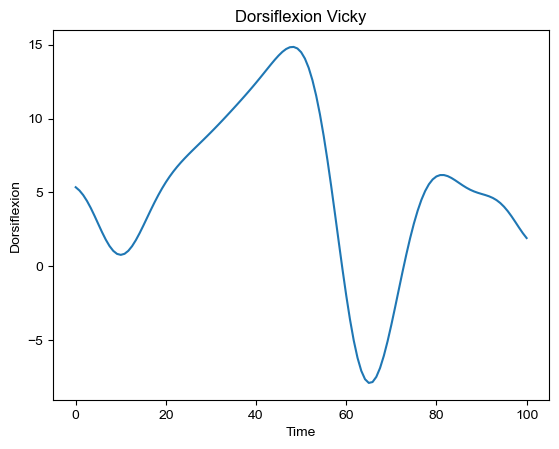

In [44]:
# Plot df_dorsiflexion
plt.plot(df_dorsiflexion['Time'], df_dorsiflexion['Dorsiflexión'])
plt.xlabel('Time')
plt.ylabel('Dorsiflexion')
plt.title('Dorsiflexion Vicky')
plt.show()

In [4]:
df = pd.read_excel('Bases/Dorsiflexion/dorsiflexion6.xlsx')
df.shape

(4058, 3)

In [5]:
tmin = 708 # 85
tmax = 2049 # 1180
df = df.loc[tmin:tmax]

# Drop de Second column
df = df.drop(df.columns[1], axis=1)

df.columns = ['Time', 'Angle']

# Adjust the time and angle
df['Time'] = df['Time'] - df['Time'][tmin]
df['Angle'] = df['Angle'] + 16

# Calculate the total time
total_time = df['Time'].max()

# Create a new column for time percentage
df['Time_Percentage'] = (df['Time']/ total_time) * 100

# Time percentage between 35 and 55
#df = df[(df['Time_Percentage'] >= 25) & (df['Time_Percentage'] < 65)]

df.shape

(1342, 3)

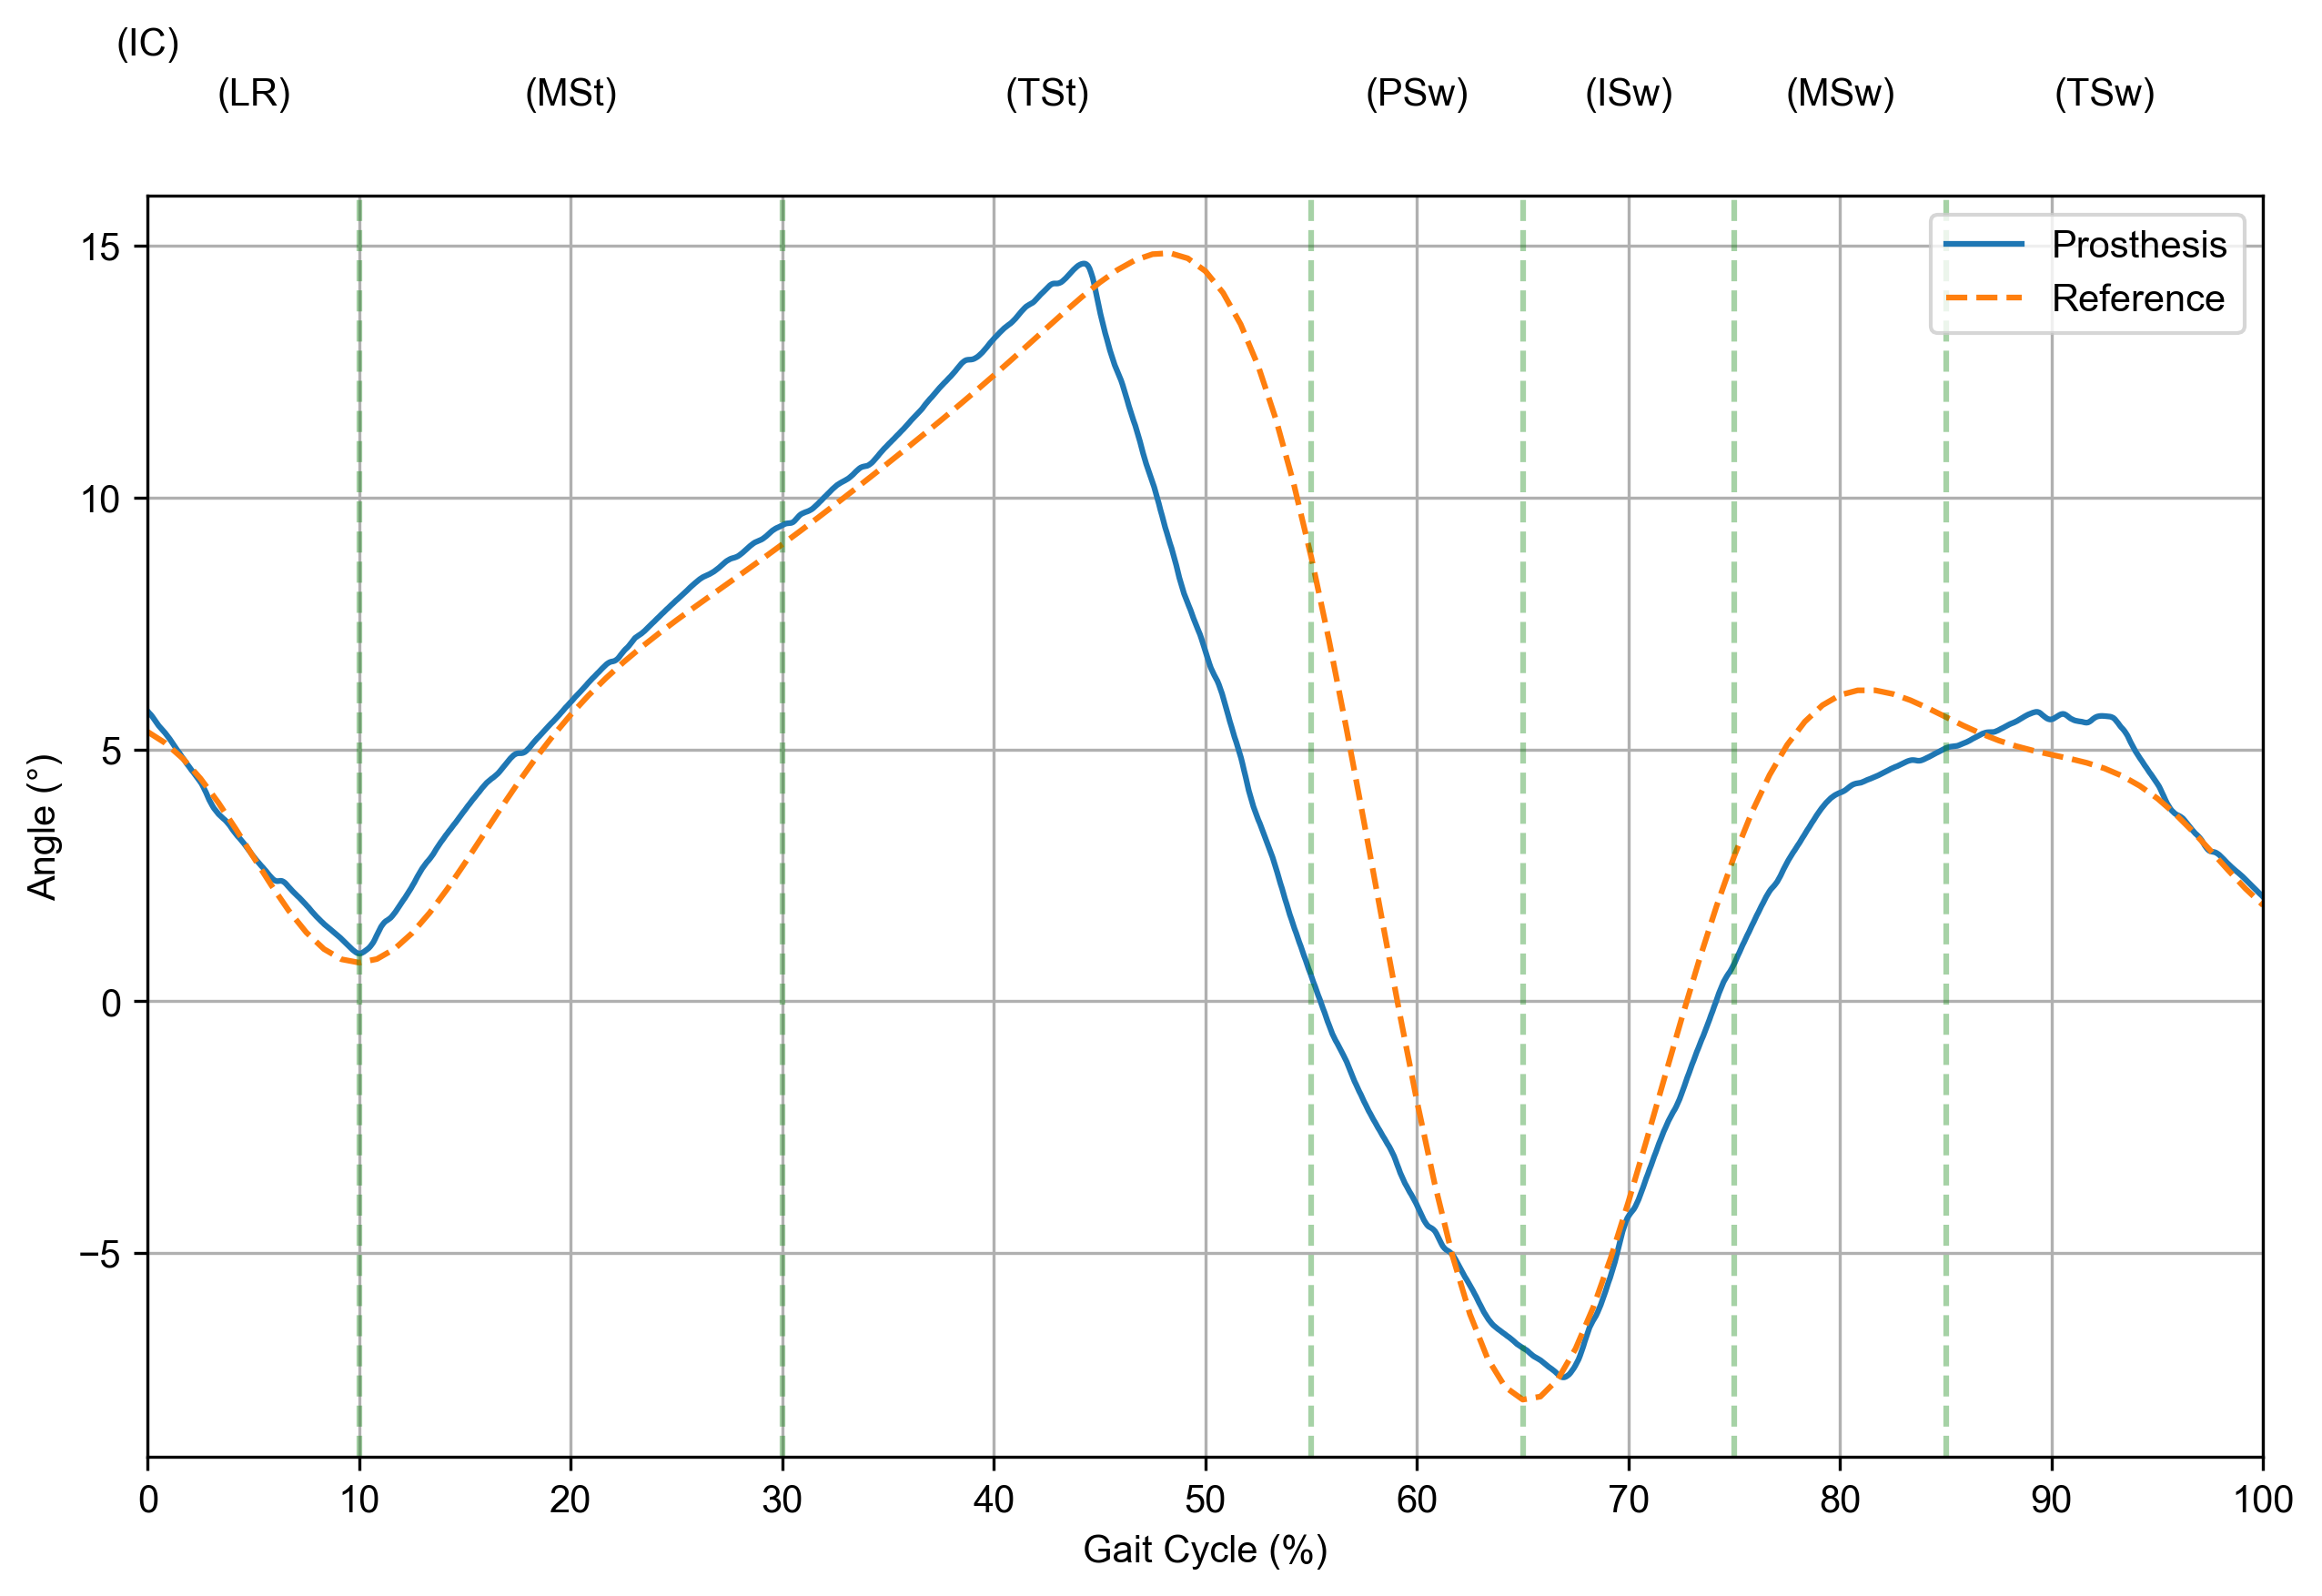

In [57]:
plot_gait_cycle(df, df_dorsiflexion, 'Dorsiflexión')

## Eversion

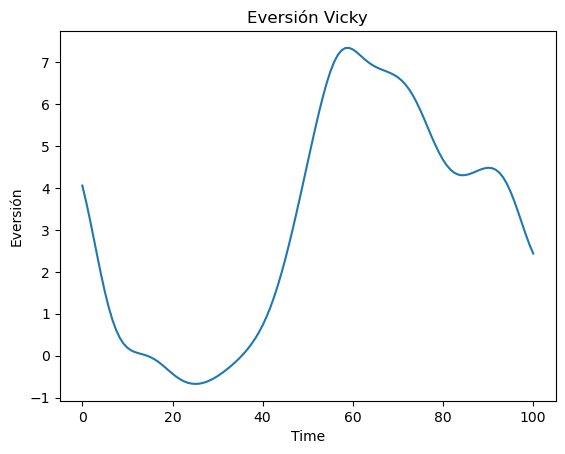

In [6]:
# Plot df_dorsiflexion
plt.plot(df_eversion['Time'], df_eversion['Eversión'])
plt.xlabel('Time')
plt.ylabel('Eversión')
plt.title('Eversión Vicky')
plt.show()

In [7]:
df = pd.read_csv('Bases/Eversion/eversion2.csv', sep=';')
df.shape

(637, 2)

In [8]:
df = pd.read_csv('Bases/Eversion/eversion2.csv', sep=';')

# Keep just the rows needed for one cycle
tmin = 293 # 248
tmax = 325 # 284
df = df.loc[tmin:tmax]

df.columns = ['Time', 'Angle']

# Adjust the time and angle
df['Time'] = df['Time'] - df['Time'][tmin] #
df['Angle'] = df['Angle'] - 119.2 #

# Calculate the total time
total_time = df['Time'].max()

# Create a new column for time percentage
df['Time_Percentage'] = (df['Time']/ total_time) * 100

# Time percentage between 35 and 55
#df = df[(df['Time_Percentage'] >= 15) & (df['Time_Percentage'] < 20)]

df.shape

(33, 3)

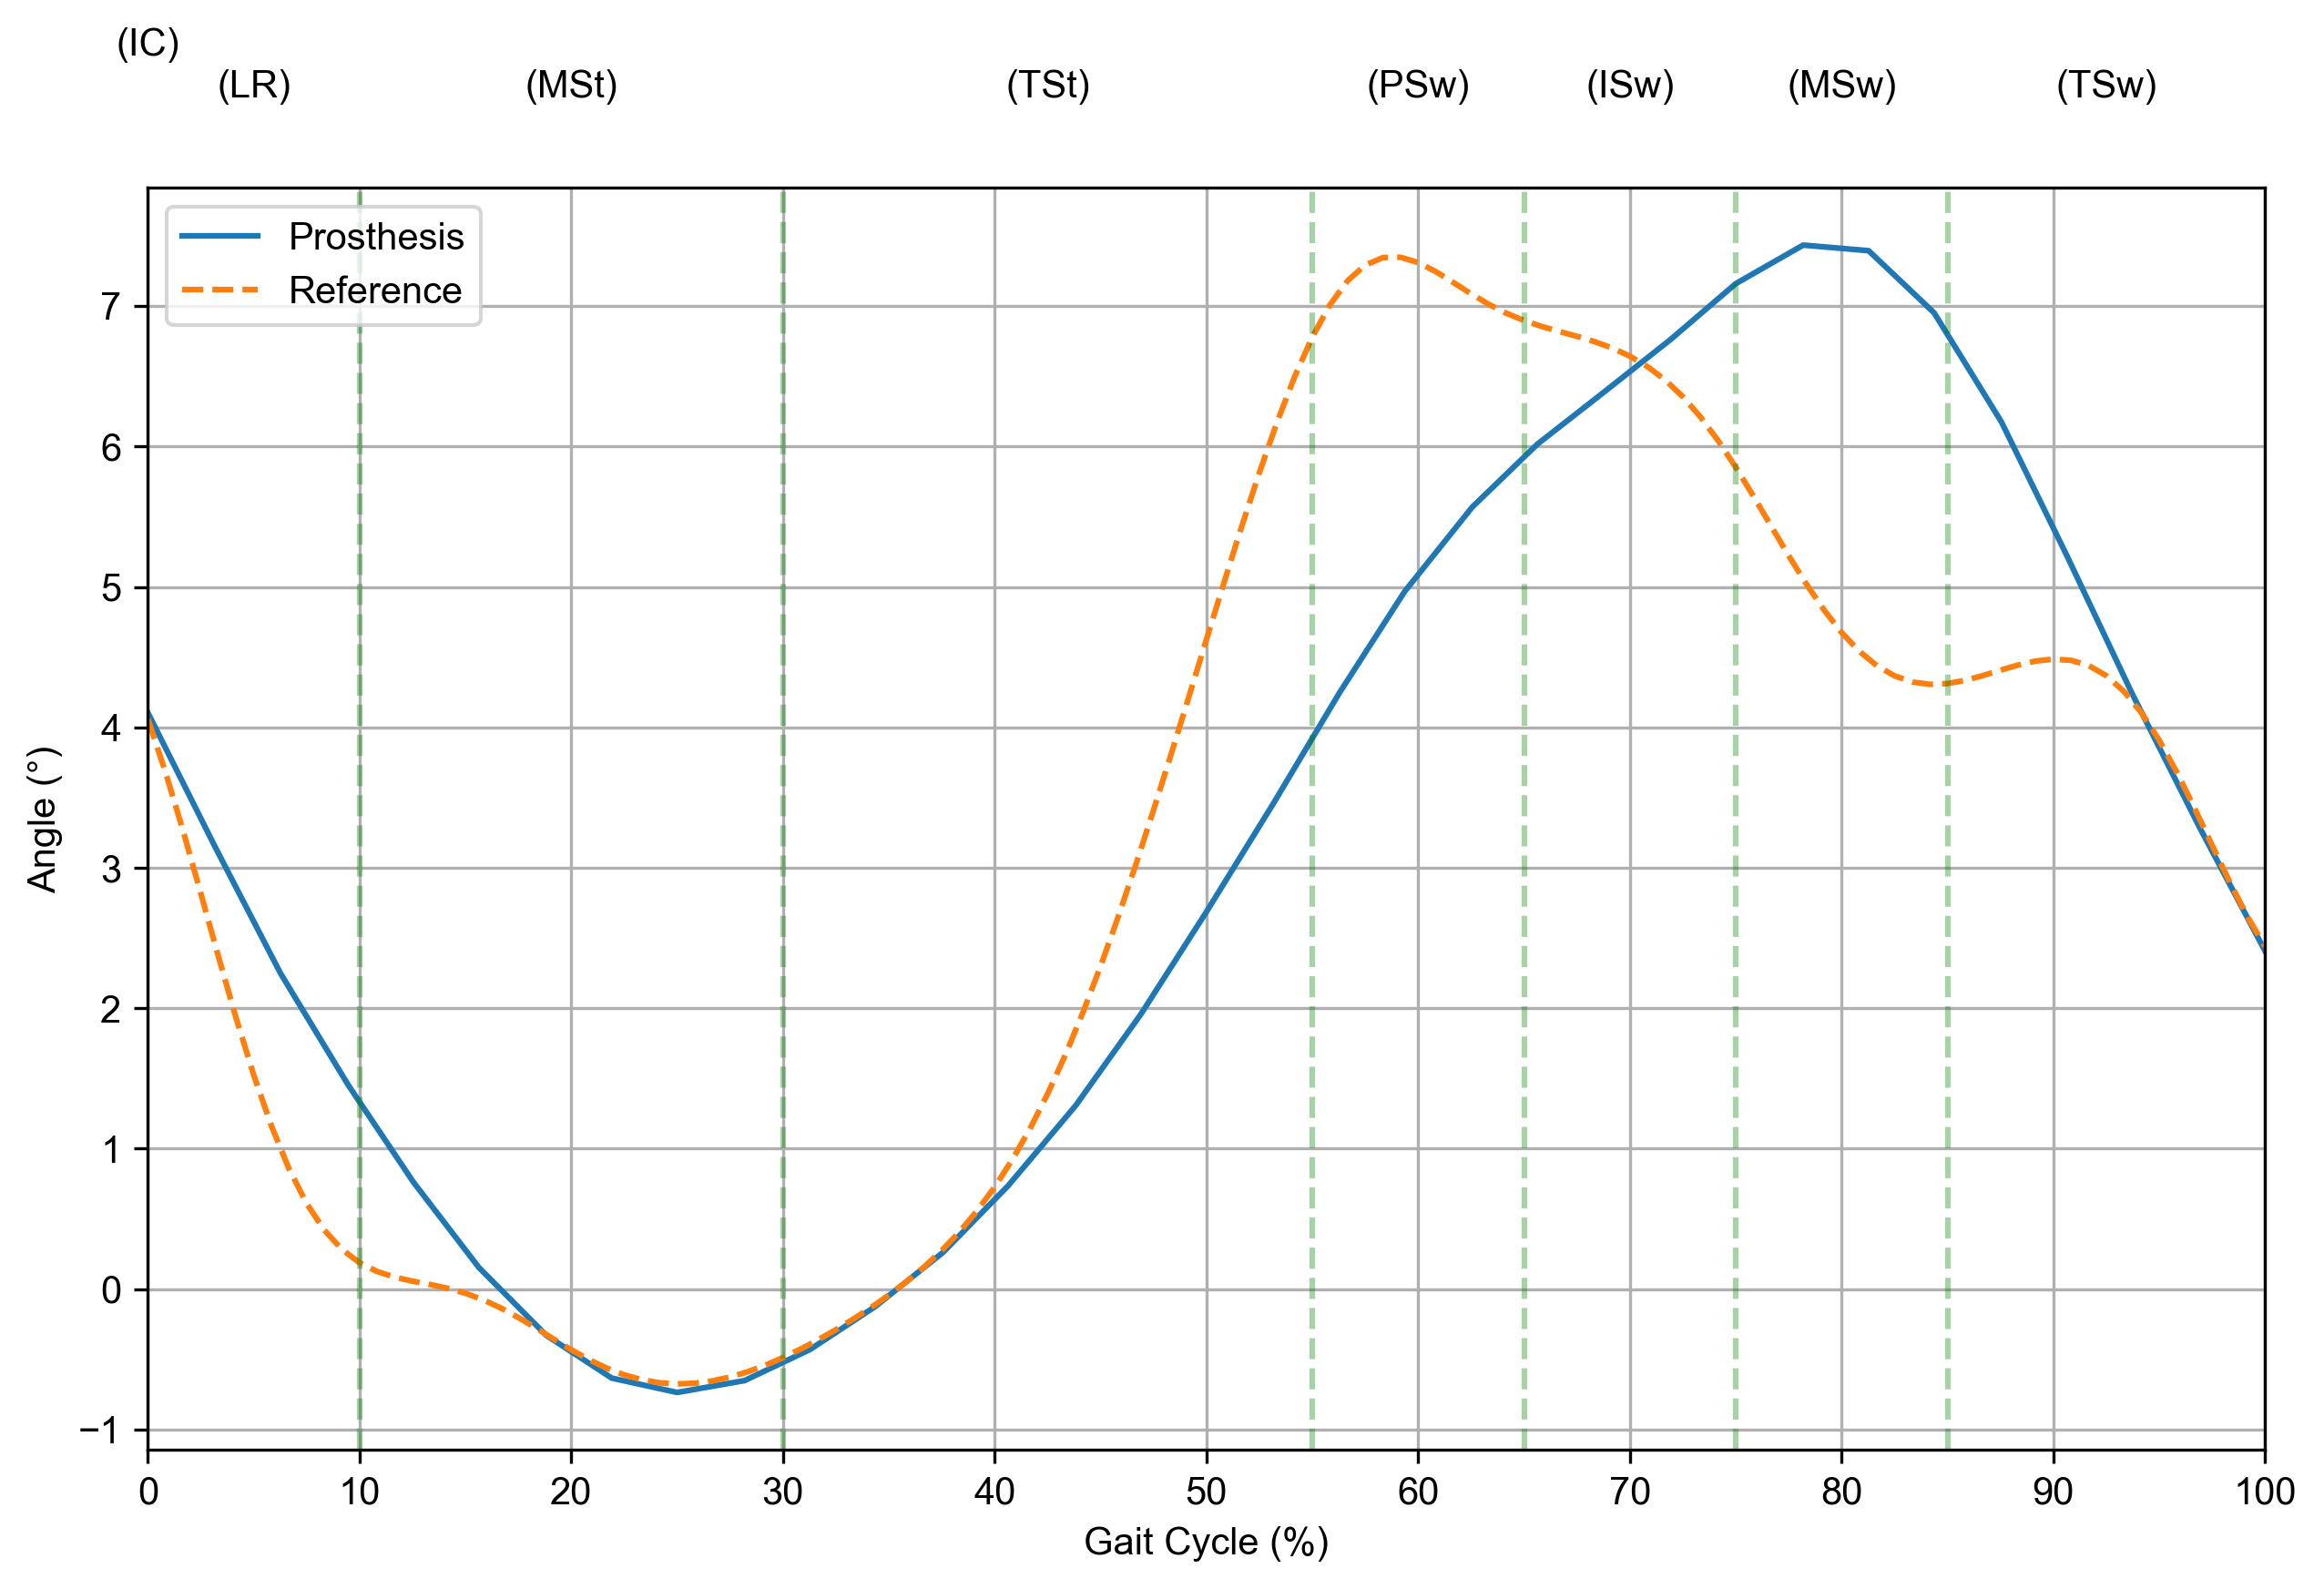

In [13]:
plot_gait_cycle(df, df_eversion, 'Eversión')

## Rotacion Interna y Externa

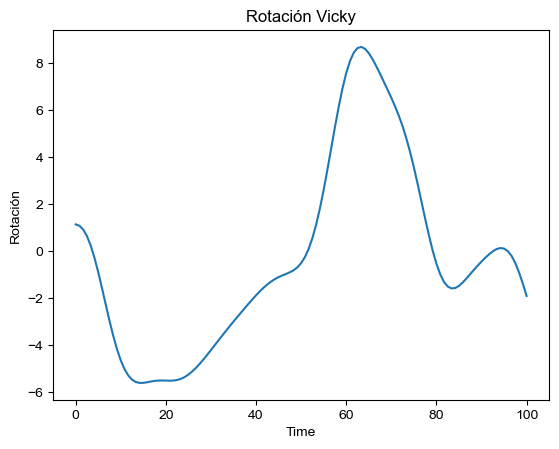

In [14]:
# Plot df_dorsiflexion
plt.plot(df_rotacion['Time'], df_rotacion['Rotación'])
plt.xlabel('Time')
plt.ylabel('Rotación')
plt.title('Rotación Vicky')
plt.show()

In [15]:
df = pd.read_csv('Bases/Rotacion/rotacion2.csv', sep=';')
df.shape

(478, 2)

In [16]:
df = pd.read_csv('Bases/Rotacion/rotacion.csv', sep=';')

# Keep just the rows needed for one cycle
tmin = 261 # 100, 126
tmax = 306 # 306
df = df.loc[tmin:tmax]

df.columns = ['Time', 'Angle']

# Adjust the time and angle
df['Time'] = df['Time'] - df['Time'][tmin] #
df['Angle'] = df['Angle'] - 6#

# Calculate the total time
total_time = df['Time'].max()

# Create a new column for time percentage
df['Time_Percentage'] = (df['Time']/ total_time) * 100

# Time percentage between 35 and 55
#df = df[(df['Time_Percentage'] >= 15) & (df['Time_Percentage'] < 20)]

df.shape

(46, 3)

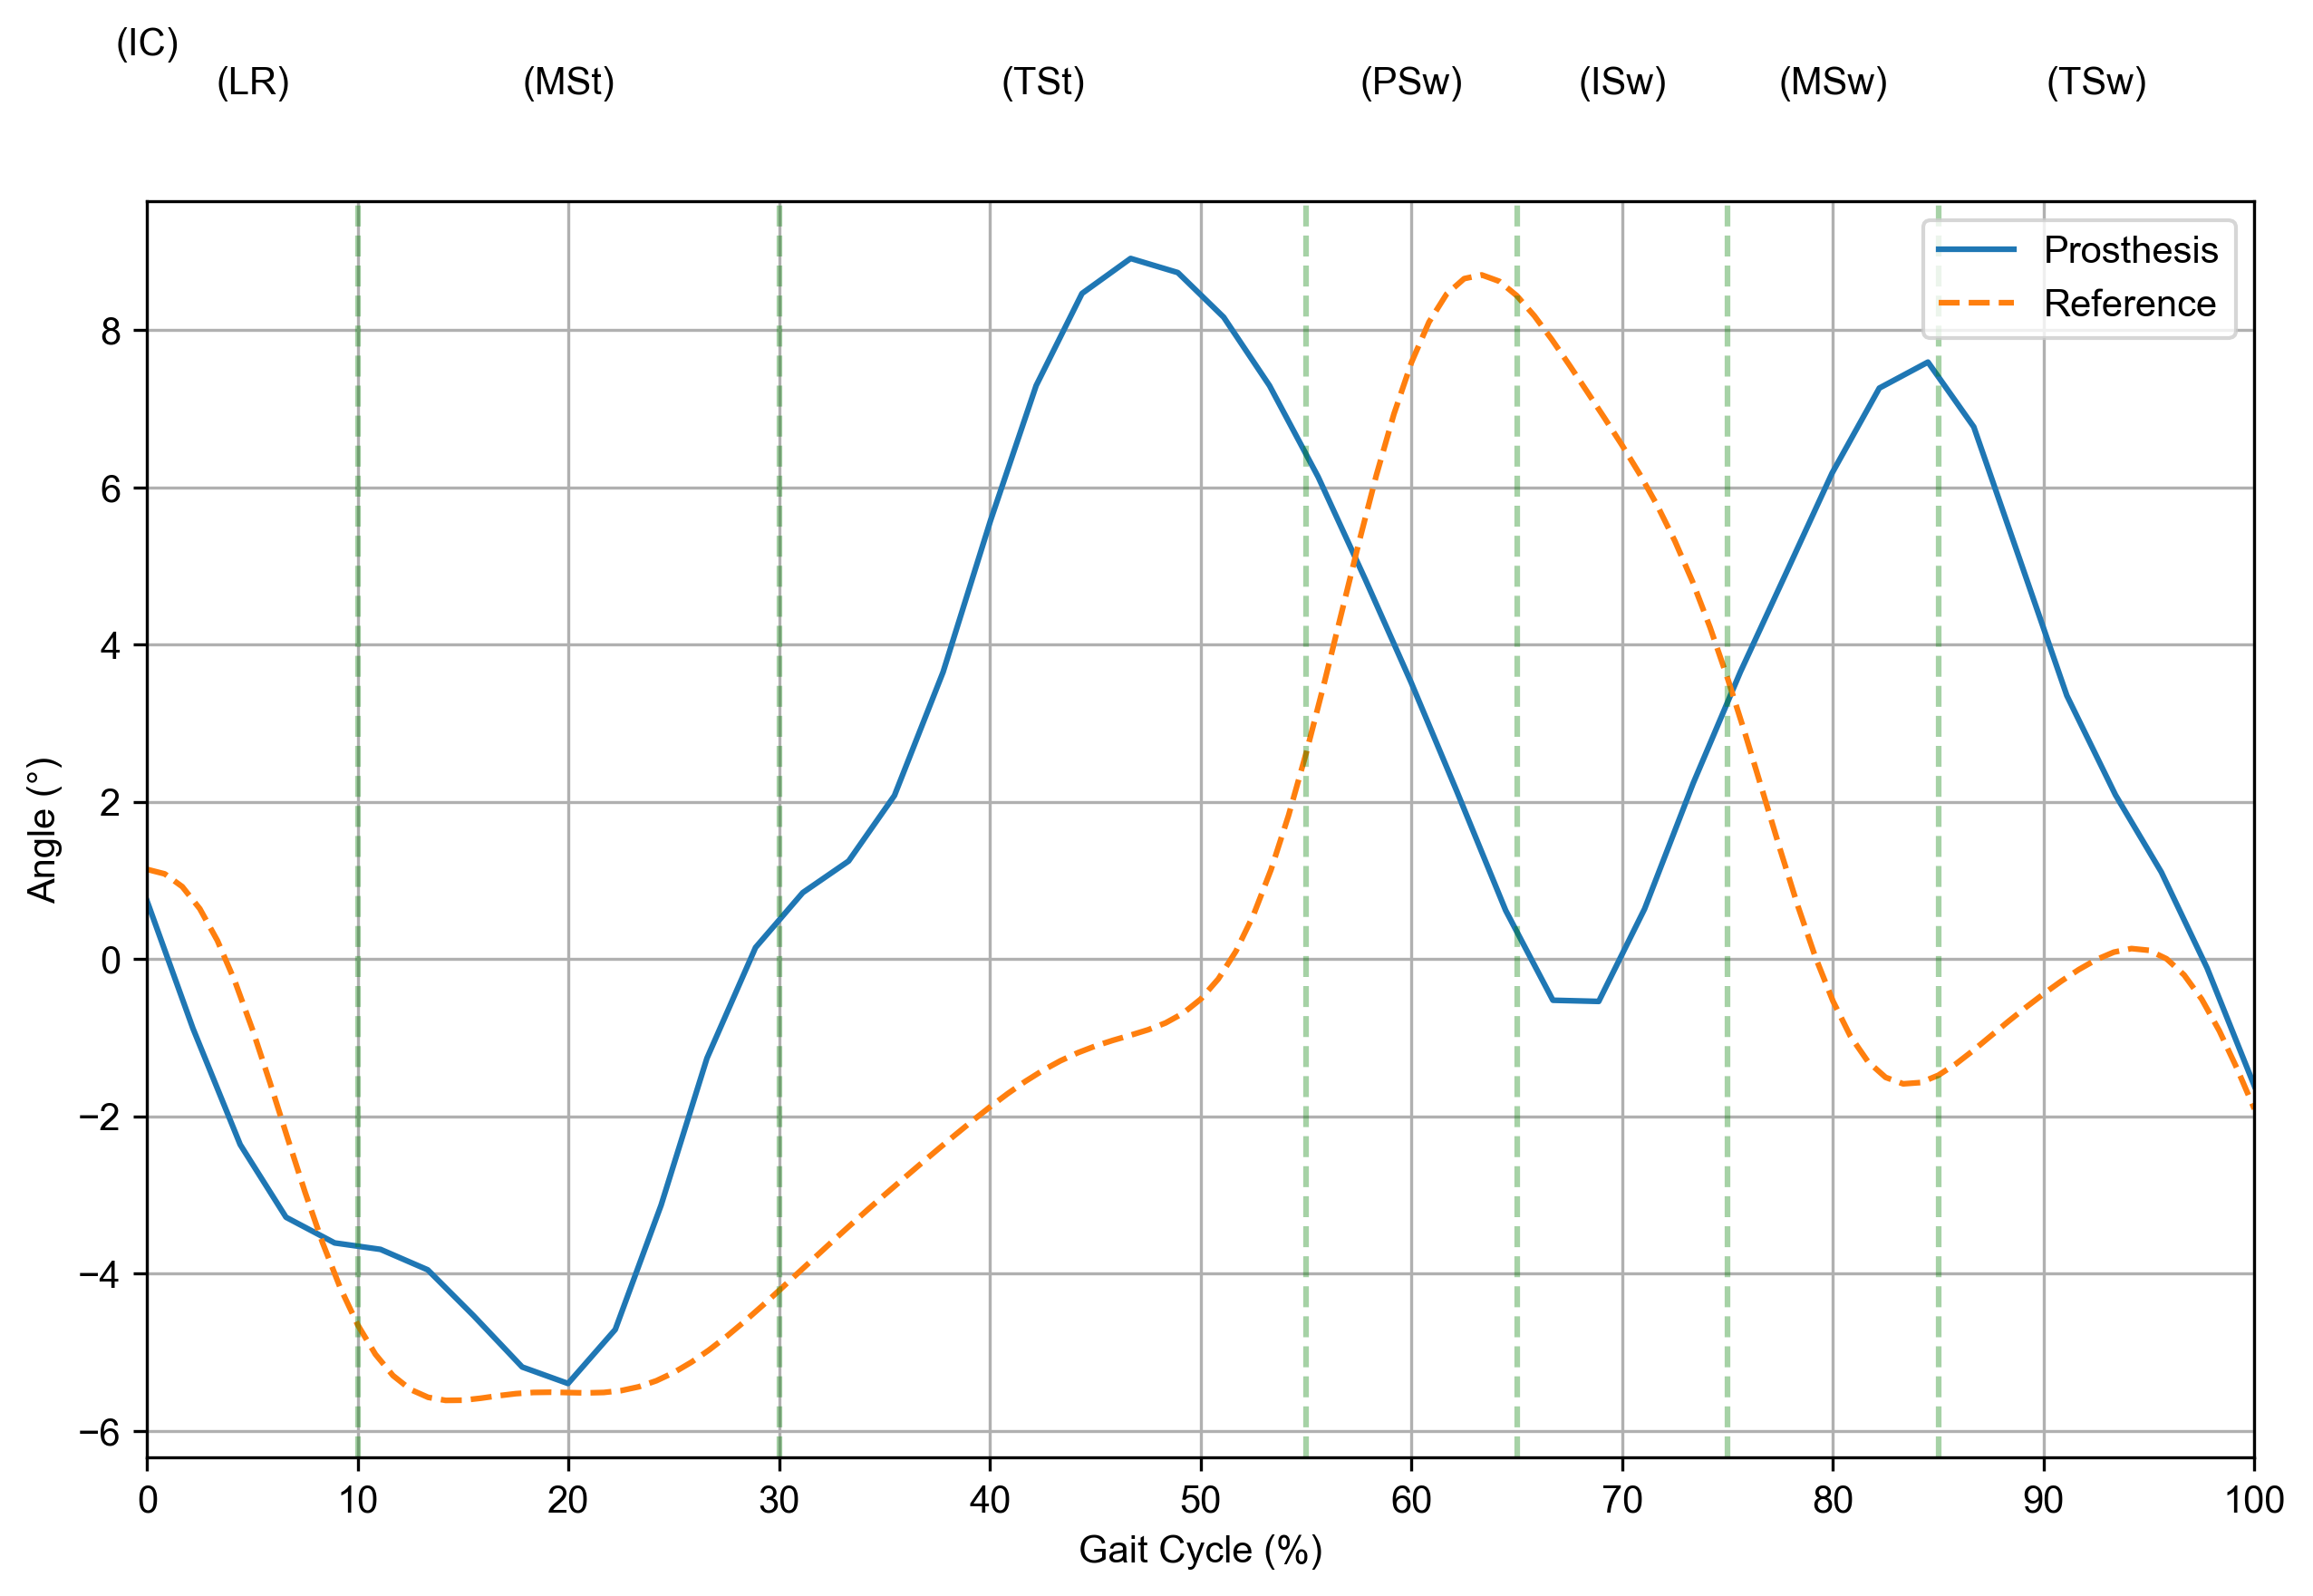

In [19]:
plot_gait_cycle(df, df_rotacion, 'Rotación')

## Grafica de Extension de Actuadores Lineales

### Dorsiflexion

In [13]:
tablaA3 = [25.10006769, 26.15532376, 27.87761288, 30.03277063, 32.14274755,
           33.66119763, 34.1975417, 33.65495348, 32.22327897, 30.25952712,
           28.13944954, 26.14593089, 24.72361905, 23.92615319, 23.25605518,
           22.66661515, 22.11582761, 21.5733724, 21.02106233, 20.4515992,
           19.86575265, 19.26738155, 18.65780794, 18.03319733, 17.38653972,
           16.71629167, 16.04011387, 15.41248058, 14.94072022, 14.79073833,
           15.17219734, 16.29940677, 18.33067735, 21.29540475, 25.03149037,
           29.17090094, 33.19674686, 37.5601747, 42.81309478, 44.71201704,
           42.26455407, 40.70152799, 38.38919581, 34.73364034, 30.10961287,
           27.81464662, 26.04324449, 24.87807397, 24.29694558, 24.19417455,
           24.41175507, 24.77624292, 25.13884164, 25.41353789, 25.59998256,
           25.77690909, 26.06283932, 26.55609705, 27.27483265, 28.12121971,
           28.89574848]

x_values = np.linspace(0, 100, len(tablaA3))

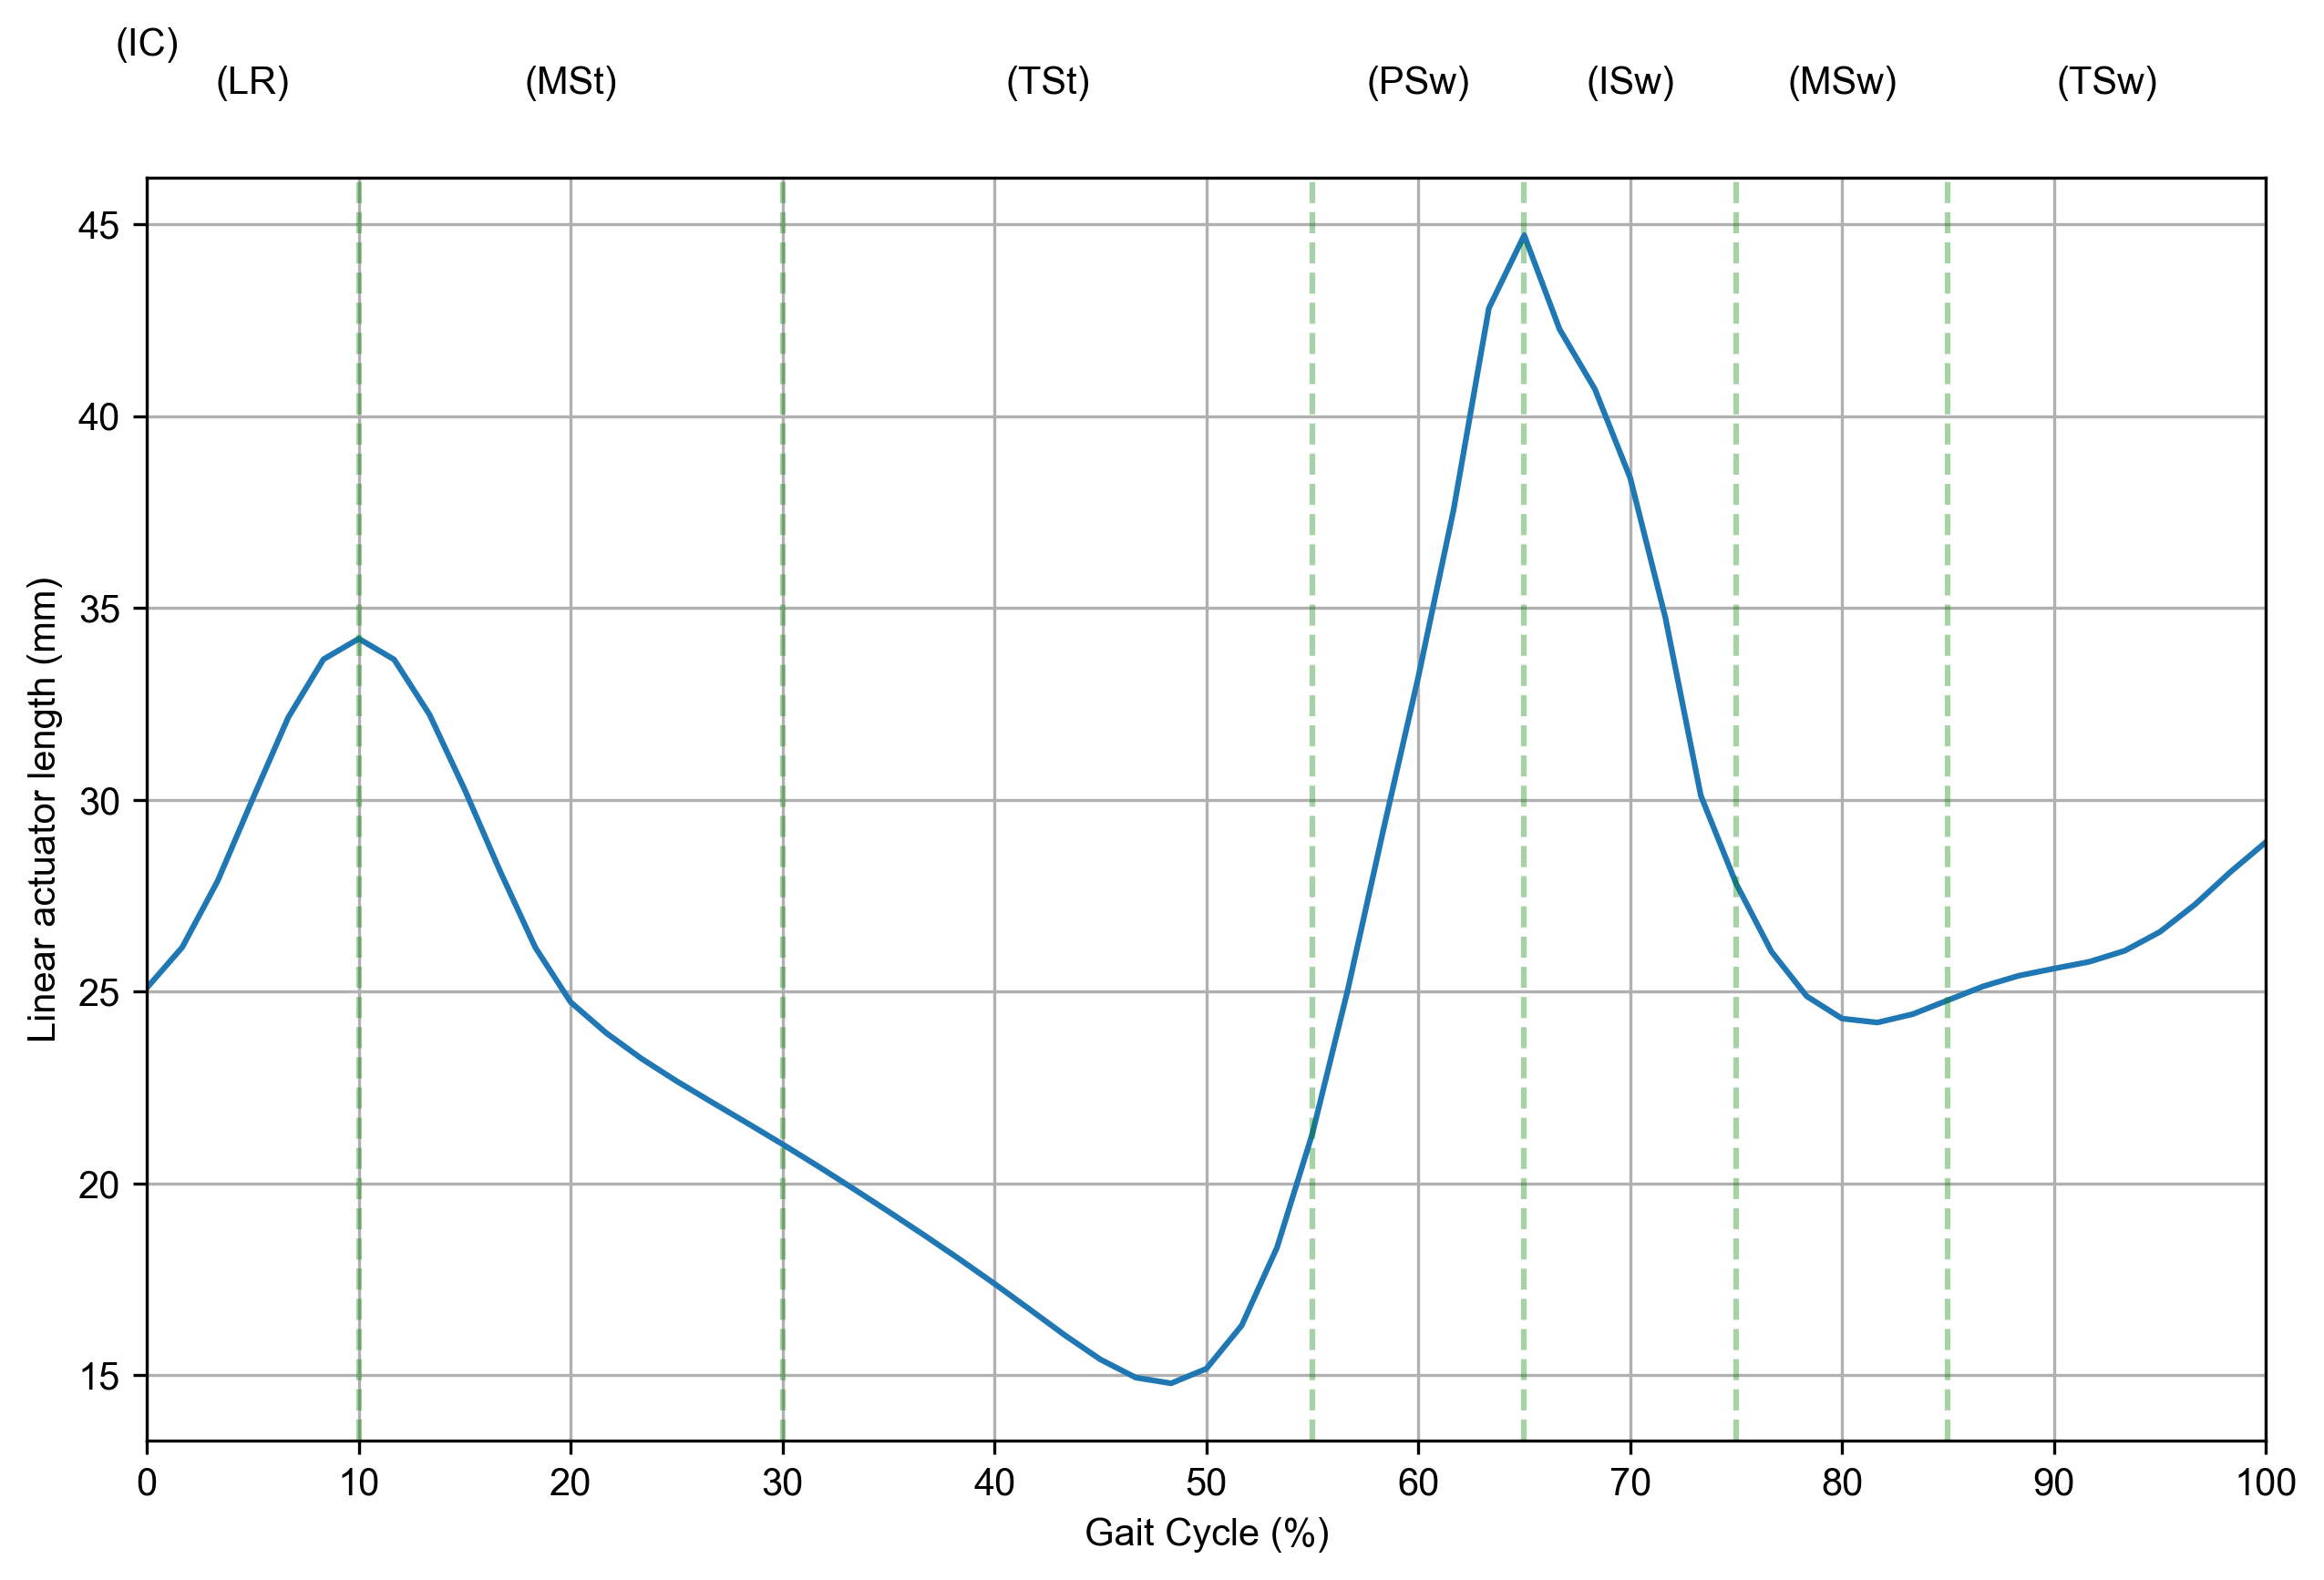

In [33]:
# Plotting
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(x_values, tablaA3)
plt.xlabel('Gait Cycle (%)')
plt.ylabel('Linear actuator length (mm)')
plt.xticks(range(0, 101, 10))
plt.xlim(0, 100)
# Add dashed vertical lines at specified percentages
vertical_lines = [10, 30, 55, 65, 75, 85]
for x in vertical_lines:
    plt.axvline(x=x, color='green', linestyle='--', alpha=0.35)

# Add labels at the top of the chart between each vertical line
labels = ['(MSt)', '(TSt)', '(PSw)', '(ISw)', '(MSw)']

plt.text(0, max(tablaA3) + 4.5, '(IC)', ha='center', va='bottom', fontsize=10, color='black')
plt.text(vertical_lines[0] / 2, max(tablaA3) + 3.5, '(LR)', ha='center', va='bottom', fontsize=10, color='black')
plt.text(92.5, max(tablaA3) + 3.5, '(TSw)', ha='center', va='bottom', fontsize=10, color='black')

for i, x in enumerate(vertical_lines):
    if i < len(vertical_lines) - 1:
        mid_point = (vertical_lines[i] + vertical_lines[i + 1]) / 2
        plt.text(mid_point, max(tablaA3) + 3.5, labels[i], ha='center', va='bottom', fontsize=10, color='black')

plt.grid(True)
plt.show()

In [3]:
tablaA3 = [34.35292769, 34.93454634, 35.58683636, 36.20339704, 36.69118264,
           37.01031723, 37.18055321, 37.25581393, 37.29384379, 37.33933278,
           37.41554951, 37.52055415, 37.63331251, 37.72852668, 37.78944037,
           37.81101207, 37.79550121, 37.74784288, 37.67416276, 37.58095433,
           37.47266106, 37.34870299, 37.20207363, 37.01992916, 36.78557576,
           36.48234633, 36.09944514, 35.63730687, 35.10878113, 34.53499445,
           33.94050786, 33.35409578, 32.81494129, 32.37461021, 32.08374017,
           31.96456661, 31.99001822, 32.09340387, 32.2056052, 32.28941513,
           32.34616109, 32.39867883, 32.47368913, 32.59681331, 32.78801872,
           33.04863587, 33.35246626, 33.6533749, 33.90481097, 34.076734,
           34.16107351, 34.16931508, 34.12813762, 34.07317855, 34.04271053,
           34.07593985, 34.21000011, 34.46366446, 34.81560931, 35.20109524,
           35.53613476]

tablaA2 = [37.64709566, 37.06545251, 36.41314983, 35.79658511, 35.30879877,
           34.98966409, 34.81942811, 34.74416739, 34.70613753, 34.66064854,
           34.58443181, 34.47942717, 34.36666881, 34.27145465, 34.21054098,
           34.18896928, 34.20448013, 34.25213846, 34.32581856, 34.41902699,
           34.52732026, 34.65127833, 34.79790769, 34.98005217, 35.2144056,
           35.51763526, 35.90053737, 36.36267878, 36.89121313, 37.46501948,
           38.05954428, 38.6460201, 39.18526445, 39.62569747, 39.91665177,
           40.0358642, 40.01040407, 39.90698503, 39.79474966, 39.71091574,
           39.6541542, 39.60162252, 39.52659308, 39.40343935, 39.21219245,
           38.95152667, 38.64764984, 38.34670464, 38.09524422, 37.92330737,
           37.83896184, 37.83071971, 37.87190002, 37.92686308, 37.9573334,
           37.92410158, 37.79003197, 37.53635295, 37.18439332, 36.79889698,
           36.46385204]

x_values = np.linspace(0, 100, len(tablaA3))

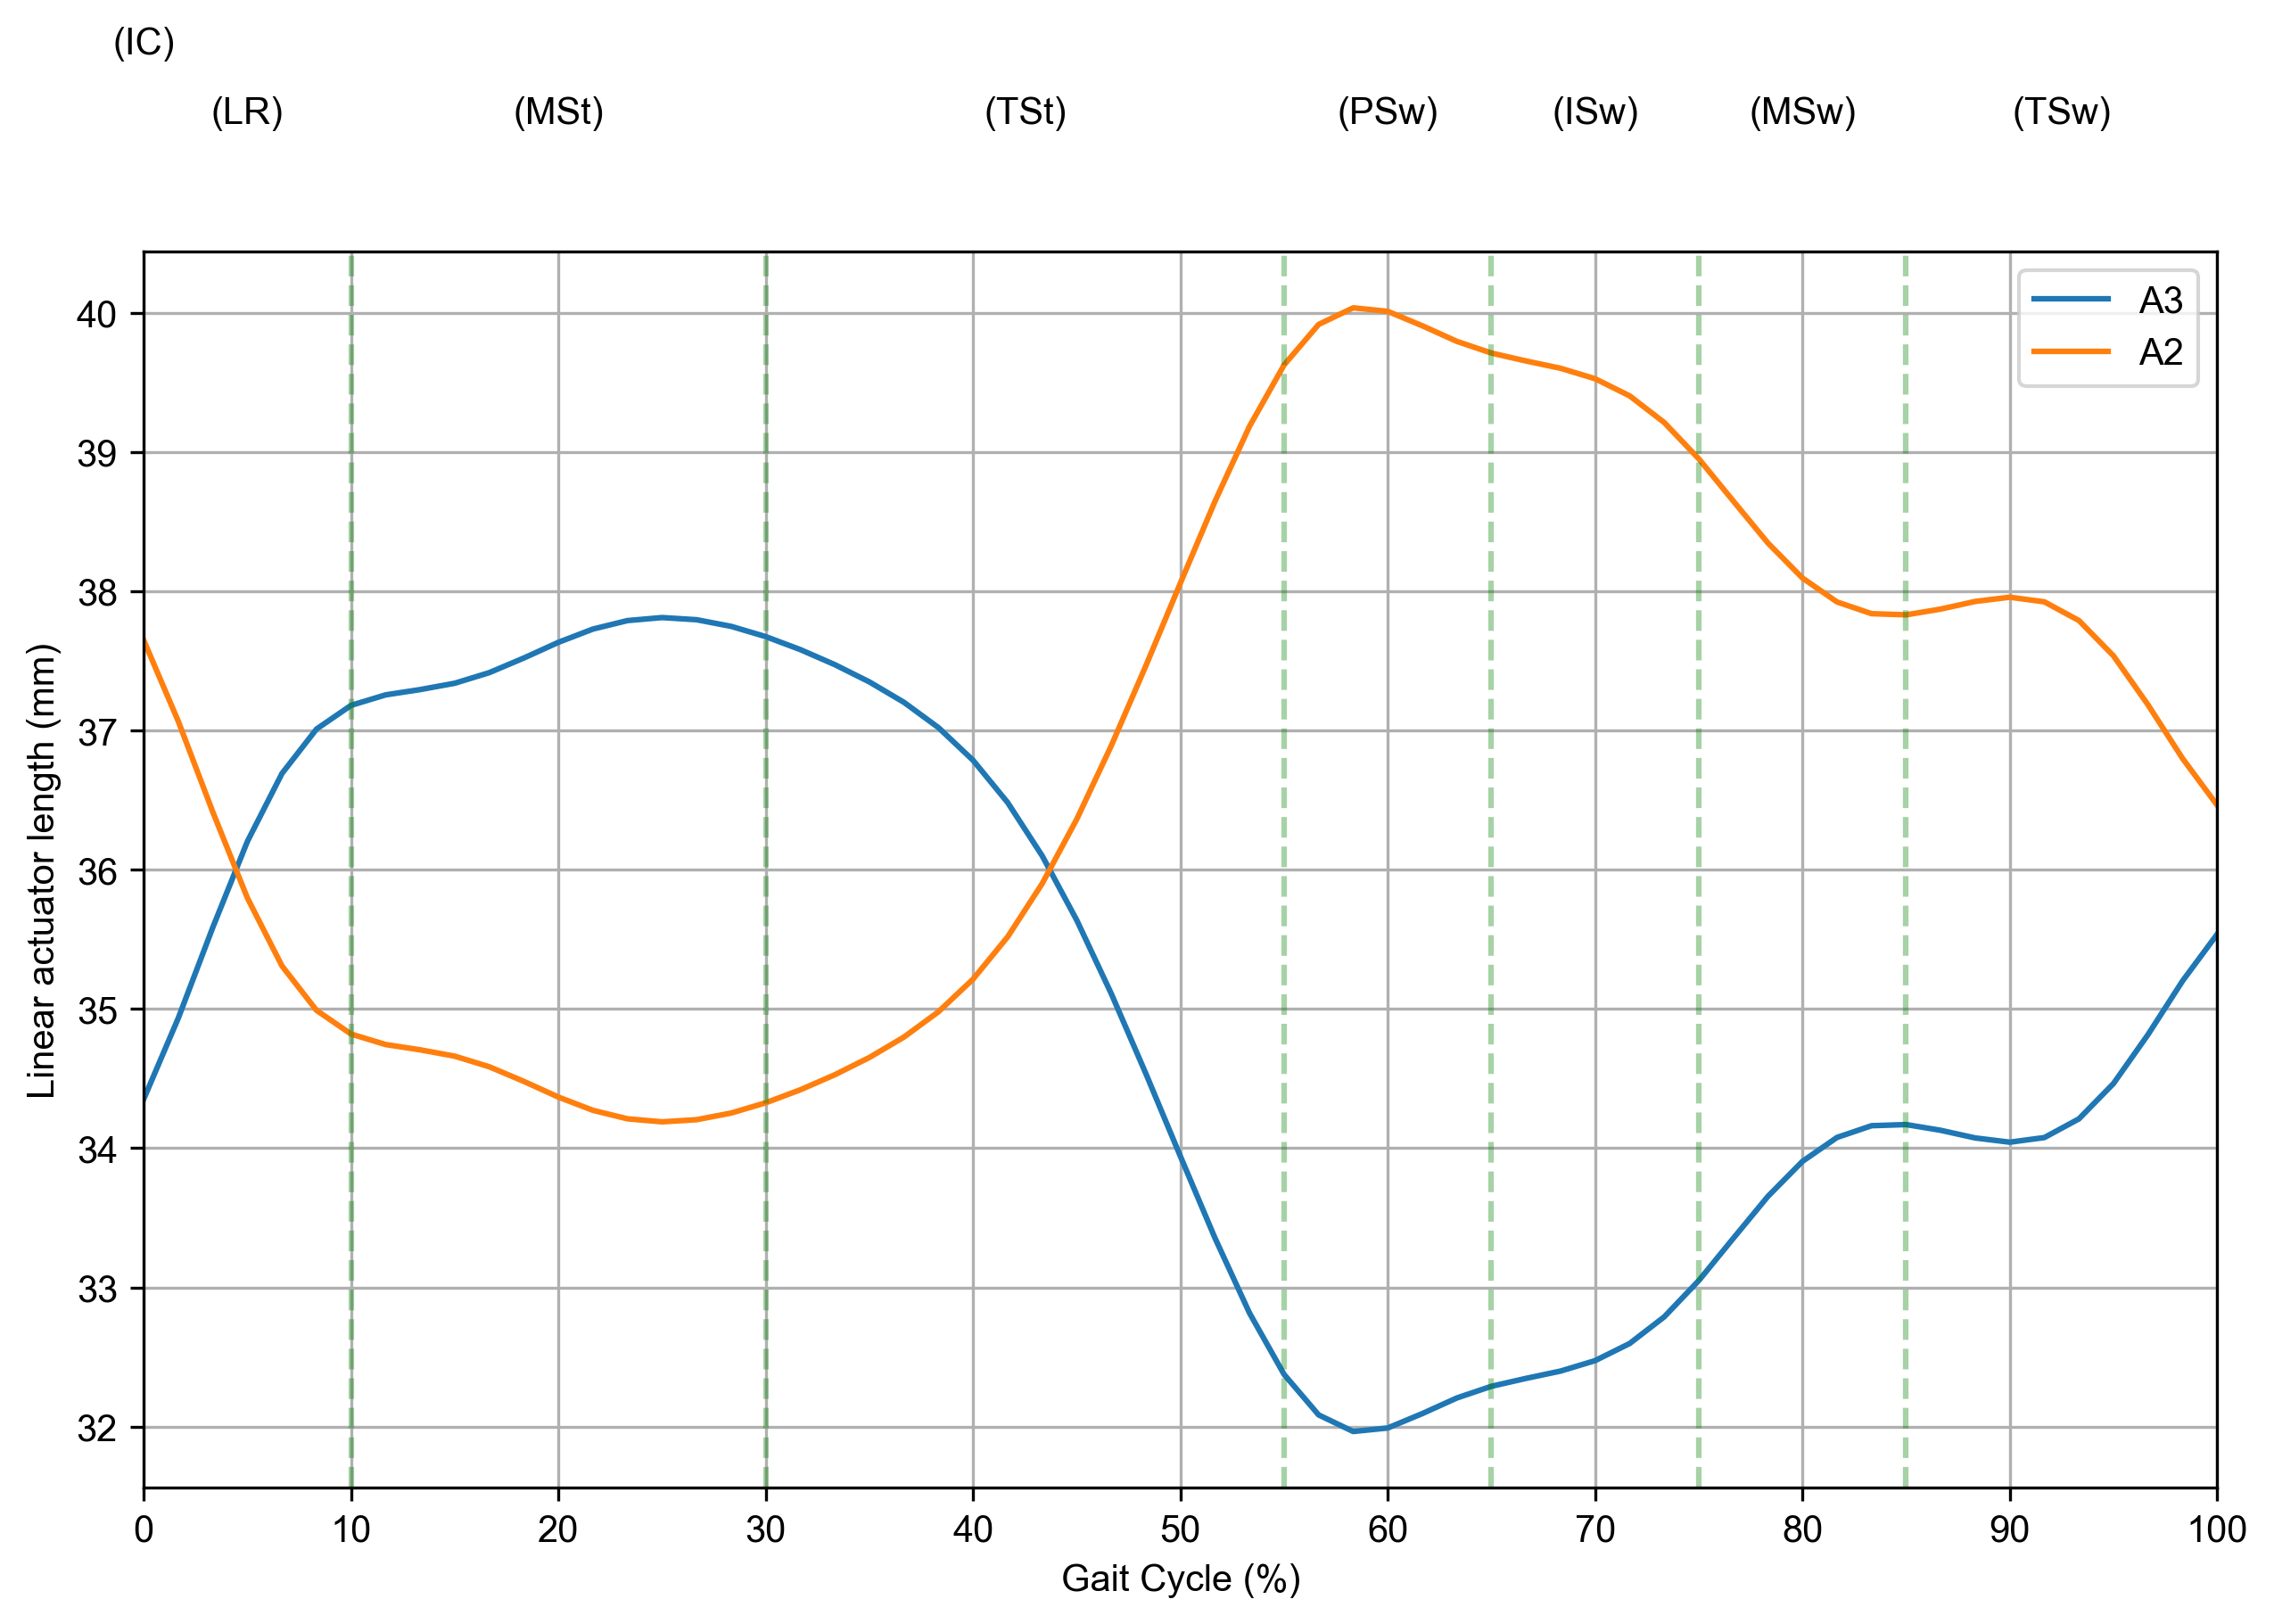

In [8]:
# Plotting
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(x_values, tablaA3, label='A3')
plt.plot(x_values, tablaA2, label='A2')
plt.xlabel('Gait Cycle (%)')
plt.ylabel('Linear actuator length (mm)')
plt.xticks(range(0, 101, 10))
plt.xlim(0, 100)
# Add dashed vertical lines at specified percentages
vertical_lines = [10, 30, 55, 65, 75, 85]
for x in vertical_lines:
    plt.axvline(x=x, color='green', linestyle='--', alpha=0.35)

# Add labels at the top of the chart between each vertical line
labels = ['(MSt)', '(TSt)', '(PSw)', '(ISw)', '(MSw)']

plt.text(0, max(tablaA3) + 4, '(IC)', ha='center', va='bottom', fontsize=10, color='black')
plt.text(vertical_lines[0] / 2, max(tablaA3) + 3.5, '(LR)', ha='center', va='bottom', fontsize=10, color='black')
plt.text(92.5, max(tablaA3) + 3.5, '(TSw)', ha='center', va='bottom', fontsize=10, color='black')

for i, x in enumerate(vertical_lines):
    if i < len(vertical_lines) - 1:
        mid_point = (vertical_lines[i] + vertical_lines[i + 1]) / 2
        plt.text(mid_point, max(tablaA3) + 3.5, labels[i], ha='center', va='bottom', fontsize=10, color='black')

plt.grid(True)

plt.legend()

plt.show()